<a href="https://colab.research.google.com/github/Gatosaito/primer-red-neuronal-python-/blob/main/Primer_Clasificador_de_Imagenes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf  # Importa la biblioteca TensorFlow y la abrevia como 'tf'
import tensorflow_datasets as tfds  # Importa la biblioteca TensorFlow Datasets y la abrevia como 'tfds'


In [2]:
# Carga del conjunto de datos Fashion MNIST utilizando TensorFlow Datasets
# - 'fashion_mnist': Especifica el nombre del conjunto de datos que se va a cargar
# - as_supervised=True: Carga los datos en un formato que incluye las imágenes y las etiquetas correspondientes
# - with_info=True: Devuelve un objeto 'Info' que contiene metadatos sobre el conjunto de datos
datos, metadatos = tfds.load('fashion_mnist', as_supervised=True, with_info=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteYQLXTP/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteYQLXTP/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
# Puedes acceder a diferentes aspectos de los metadatos para obtener información sobre el conjunto de datos
# Por ejemplo, puedes imprimir la descripción del conjunto de datos para entender su contenido y propósito
metadatos

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_dir=PosixGPath('/tmp/tmpkjmsii4mtfds'),
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao an

In [5]:
# División del conjunto de datos cargado en conjuntos de entrenamiento y prueba
# 'datos['train']': Conjunto de datos de entrenamiento que contiene imágenes y etiquetas para el entrenamiento del modelo
# 'datos['test']': Conjunto de datos de prueba que contiene imágenes y etiquetas para evaluar el rendimiento del modelo
datos_entrenamiento, datos_pruebas = datos['train'], datos['test']


In [6]:
# Extracción de los nombres de las clases del conjunto de datos cargado
# 'metadatos.features['label'].names': Obtiene los nombres de las clases del conjunto de datos
nombres_clases = metadatos.features['label'].names


In [7]:
nombres_clases

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [8]:
# Función para normalizar las imágenes y etiquetas
def normalizar(imagenes, etiquetas):
    imagenes = tf.cast(imagenes, tf.float32)  # Convertir las imágenes a tipo float32
    imagenes /= 255  # Normalizar los valores de píxeles de 0-255 a 0-1
    return imagenes, etiquetas

# Normalizar los datos de entrenamiento y pruebas utilizando la función de normalización definida
datos_entrenamiento = datos_entrenamiento.map(normalizar)  # Aplicar normalización al conjunto de datos de entrenamiento
datos_pruebas = datos_pruebas.map(normalizar)  # Aplicar normalización al conjunto de datos de prueba

# Agregar los conjuntos de datos normalizados a la caché para mejorar el rendimiento
datos_entrenamiento = datos_entrenamiento.cache()  # Agregar el conjunto de datos de entrenamiento a la caché
datos_pruebas = datos_pruebas.cache()  # Agregar el conjunto de datos de prueba a la caché


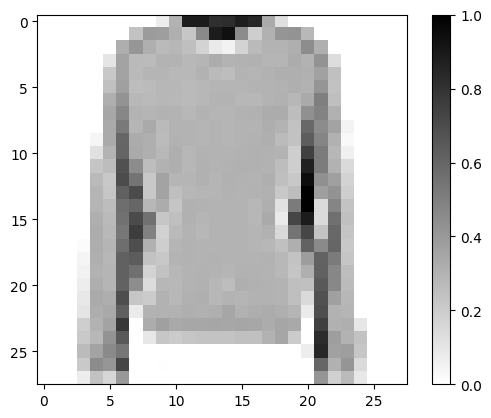

In [9]:
# Obtener la primera imagen del conjunto de datos de entrenamiento
for imagen, etiqueta in datos_entrenamiento.take(1):
    break

# Convertir la imagen a un arreglo numpy y cambiar su forma a (28, 28)
imagen = imagen.numpy().reshape((28, 28))

# Importar la biblioteca Matplotlib para la visualización
import matplotlib.pyplot as plt

# Mostrar la imagen utilizando Matplotlib
plt.figure()  # Crear una nueva figura
plt.imshow(imagen, cmap=plt.cm.binary)  # Mostrar la imagen en escala de grises
plt.colorbar()  # Agregar una barra de color para mostrar la escala
plt.grid(False)  # Desactivar las líneas de la cuadrícula
plt.show()  # Mostrar la imagen


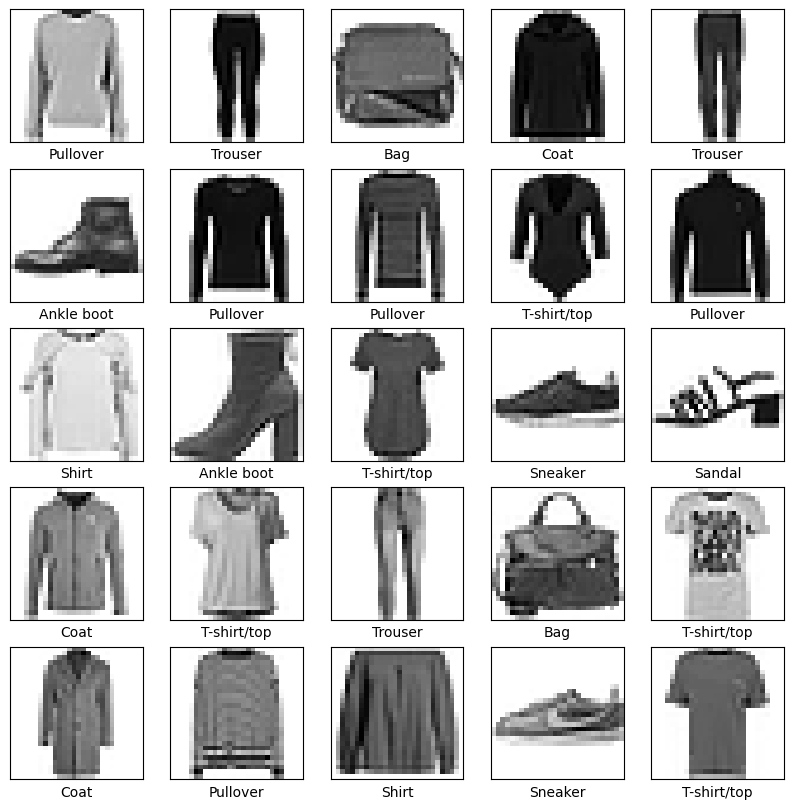

In [10]:
# Crear una nueva figura de matplotlib con tamaño 10x10 pulgadas
plt.figure(figsize=(10,10))

# Iterar sobre los primeros 25 elementos del conjunto de datos de entrenamiento
for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):

  # Convertir la imagen de tensor de TensorFlow a un arreglo numpy y remodelarla a una matriz de 28x28 píxeles
  imagen = imagen.numpy().reshape((28,28))

  # Crear un subplot en la posición i+1 en una cuadrícula de 5x5
  plt.subplot(5,5,i+1)

  # Eliminar las marcas en los ejes x e y para no mostrar los números de los ejes
  plt.xticks([])
  plt.yticks([])

  # Desactivar las líneas de la cuadrícula en el gráfico
  plt.grid(False)

  # Mostrar la imagen utilizando una paleta de colores binaria (blanco y negro)
  plt.imshow(imagen, cmap=plt.cm.binary)

  # Establecer el texto en el eje x con la etiqueta correspondiente a la imagen actual
  # Utilizando el diccionario nombres_clases para mapear la etiqueta a su nombre
  plt.xlabel(nombres_clases[etiqueta])

# Mostrar la figura completa con todas las imágenes y etiquetas
plt.show()

In [11]:
# Definir el modelo Sequential
modelo = tf.keras.Sequential(
    [
        # Capa de aplanamiento para convertir la entrada (28x28) en un vector unidimensional (784)
        tf.keras.layers.Flatten(input_shape=(28,28,1)),

        # Capa totalmente conectada con 50 neuronas y activación ReLU
        tf.keras.layers.Dense(50, activation=tf.nn.relu),

        # Capa totalmente conectada con 50 neuronas y activación ReLU
        tf.keras.layers.Dense(50, activation=tf.nn.relu),

        # Capa de salida con 10 neuronas (una para cada clase) y activación softmax
        tf.keras.layers.Dense(10, activation=tf.nn.softmax),
    ])

In [12]:
modelo.compile(
    optimizer='adam',  # Algoritmo de optimización utilizado para entrenar el modelo
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  # Función de pérdida utilizada para calcular el error del modelo
    metrics=['accuracy']  # Métricas utilizadas para evaluar el rendimiento del modelo durante el entrenamiento
)

In [13]:
# Obtener el número de ejemplos en el conjunto de entrenamiento a partir de los metadatos del conjunto de datos
num_ej_entrenamiento = metadatos.splits["train"].num_examples

# Obtener el número de ejemplos en el conjunto de prueba a partir de los metadatos del conjunto de datos
num_ej_pruebas = metadatos.splits["test"].num_examples


In [14]:
print(num_ej_entrenamiento) # Imprime el número total de ejemplos en el conjunto de entrenamiento
print(num_ej_pruebas) # Imprime el número total de ejemplos en el conjunto de prueba

60000
10000


In [15]:
# El trabajo por lotes permite que los entrenamientos con una gran cantidad de datos se realicen de manera más eficiente
TAMANO_LOTE = 32

# Shuffle y repeat hacen que los datos estén mezclados de manera aleatoria para evitar que la red neuronal aprenda el orden de los datos de entrenamiento
datos_entrenamiento = datos_entrenamiento.repeat().shuffle(num_ej_entrenamiento).batch(TAMANO_LOTE)

# El conjunto de datos de entrenamiento se repite (para mantener el mismo tamaño en cada época), se mezcla y luego se agrupa en lotes del tamaño especificado
# Esto se hace para garantizar que cada época del entrenamiento vea una combinación aleatoria de datos
# TAMANO_LOTE define el tamaño de cada lote de datos utilizado durante el entrenamiento

# El conjunto de datos de prueba no se repite ni se mezcla, solo se agrupa en lotes del tamaño especificado
datos_pruebas = datos_pruebas.batch(TAMANO_LOTE)


In [16]:
import math

# Entrenar el modelo utilizando el método fit
# Se especifica el conjunto de datos de entrenamiento (datos_entrenamiento)
# Se establece el número de épocas de entrenamiento en 5
# El parámetro 'steps_per_epoch' se calcula para asegurar que se recorra todo el conjunto de entrenamiento en cada época
# 'steps_per_epoch' se calcula dividiendo el número total de ejemplos de entrenamiento entre el tamaño del lote y redondeando hacia arriba
# Esto asegura que en cada época se realice una iteración sobre todos los ejemplos de entrenamiento
historial = modelo.fit(datos_entrenamiento, epochs=5, steps_per_epoch= math.ceil(num_ej_entrenamiento/TAMANO_LOTE))

Epoch 1/5
1875/1875 [==============================] - 13s 3ms/step - loss: 0.5175 - accuracy: 0.8172
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3828 - accuracy: 0.8614
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3492 - accuracy: 0.8716
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3294 - accuracy: 0.8797
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3090 - accuracy: 0.8860


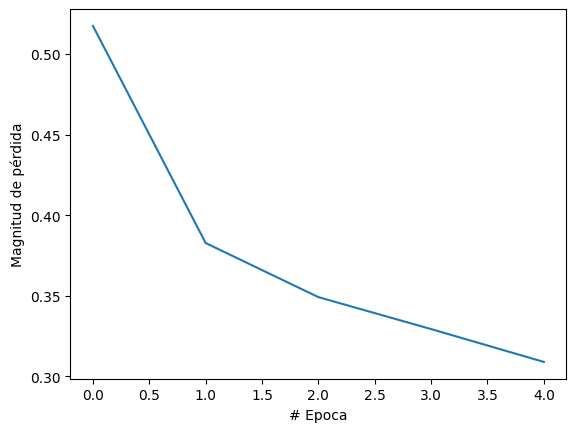

In [17]:
# Establecer la etiqueta del eje x como "# Epoca"
plt.xlabel("# Epoca")

# Establecer la etiqueta del eje y como "Magnitud de pérdida"
plt.ylabel("Magnitud de pérdida")

# Trazar la magnitud de la pérdida del modelo a lo largo de las épocas utilizando el historial de entrenamiento
# Se accede a la lista de pérdidas del historial de entrenamiento utilizando la clave "loss"
plt.plot(historial.history["loss"])

1/1 [==============================] - 0s 116ms/step


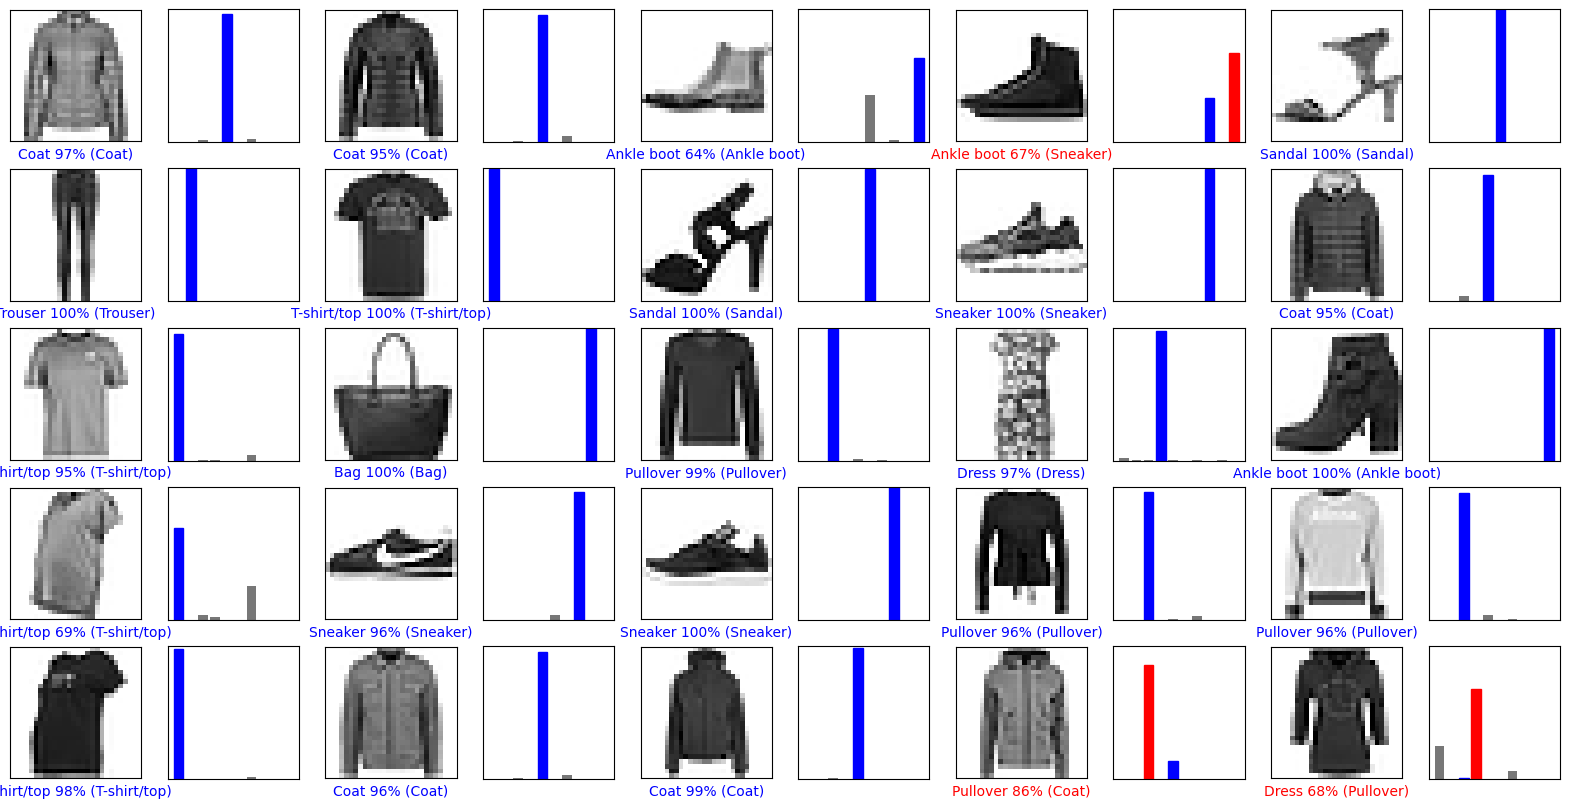

In [18]:
# Importar la biblioteca numpy
import numpy as np

# Iterar sobre los datos de prueba y realizar predicciones
for imagenes_prueba, etiquetas_prueba in datos_pruebas.take(1):
    imagenes_prueba = imagenes_prueba.numpy()
    etiquetas_prueba = etiquetas_prueba.numpy()
    predicciones = modelo.predict(imagenes_prueba)

# Definir una función para graficar una imagen junto con su etiqueta predicha y real
def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
    arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    # Mostrar la imagen en escala de grises
    plt.imshow(img[...,0], cmap=plt.cm.binary)

    # Obtener la etiqueta predicha
    etiqueta_prediccion = np.argmax(arr_predicciones)
    # Establecer el color de la etiqueta en azul si la predicción es correcta, en rojo si es incorrecta
    color = 'blue' if etiqueta_prediccion == etiqueta_real else 'red'

    # Mostrar la etiqueta predicha y la probabilidad junto con la etiqueta real
    plt.xlabel("{} {:2.0f}% ({})".format(nombres_clases[etiqueta_prediccion],
                                100*np.max(arr_predicciones),
                                nombres_clases[etiqueta_real]),
                                color=color)

# Definir una función para graficar la distribución de probabilidad de predicción de una imagen
def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
    arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    grafica = plt.bar(range(10), arr_predicciones, color="#777777")
    plt.ylim([0, 1])
    etiqueta_prediccion = np.argmax(arr_predicciones)

    # Establecer el color de la barra correspondiente a la etiqueta predicha en rojo, y a la etiqueta real en azul
    grafica[etiqueta_prediccion].set_color('red')
    grafica[etiqueta_real].set_color('blue')

# Definir el número de filas y columnas para la cuadrícula de imágenes
filas = 5
columnas = 5
num_imagenes = filas*columnas

# Crear una nueva figura de matplotlib con el tamaño adecuado para la cuadrícula de imágenes
plt.figure(figsize=(2*2*columnas, 2*filas))

# Iterar sobre las imágenes de prueba y graficarlas junto con sus predicciones y etiquetas
for i in range(num_imagenes):
    plt.subplot(filas, 2*columnas, 2*i+1)
    graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
    plt.subplot(filas, 2*columnas, 2*i+2)
    graficar_valor_arreglo(i, predicciones, etiquetas_prueba)


In [21]:
# Seleccionar una imagen de prueba específica (en este caso, la imagen en el índice 5)
imagen = imagenes_prueba[10]

# Convertir la imagen en un array numpy y agregar una dimensión adicional para que coincida con la entrada del modelo
imagen = np.array([imagen])

# Realizar la predicción utilizando el modelo entrenado
prediccion = modelo.predict(imagen)

# Imprimir la etiqueta de la predicción más probable
print("Predicción: " + nombres_clases[np.argmax(prediccion[0])])


1/1 [==============================] - 0s 48ms/step
Predicción: T-shirt/top
